# Towards An <strong>E</strong>nd-to-<strong>E</strong>nd Framework for <strong>F</strong>low-<strong>G</strong>uided <strong>V</strong>ideo <strong>I</strong>npainting (CVPR 2022)

In this demo, you can try to inpaint an example video through our framework.

In [ ]:
# https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/train')#, force_remount=True)

Mounted at /content/train


# Setup

In [ ]:
#@title Setup environment and code (may take some time)

# Install Pytorch
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.5/index.html

# prepare code
import os
CODE_DIR = 'E2FGVI'
try:
  os.makedirs(f'./{CODE_DIR}')
except:
  pass
!git clone https://github.com/MCG-NKU/E2FGVI.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 19 kB/s 
     |████████████████████████████████| 6.6 MB 75.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.5.1+cu101 which

In [ ]:
#@title Download model with PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "release_model")
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        downloaded = self.drive.CreateFile({'id':file_id})
        downloaded.FetchMetadata(fetch_all=True)
        downloaded.GetContentFile(file_dst)

downloader = Downloader(download_with_pydrive)
path = {"id": "1tNJMTJ2gmWdIXJoHVi5-H504uImUiJW9", "name": "E2FGVI_CVPR22_models.zip"}
downloader.download_file(file_id=path["id"], file_name=path["name"])

os.chdir(downloader.save_dir)
!unzip E2FGVI_CVPR22_models.zip
os.chdir('..')

Archive:  E2FGVI_CVPR22_models.zip
  inflating: E2FGVI-CVPR22.pth       
  inflating: i3d_rgb_imagenet.pt     


# Define Utility Functions


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation

import cv2
from PIL import Image
import numpy as np
import importlib
import os
import argparse
from tqdm import tqdm
import torch

# rc('animation', html='jshtml')

from core.utils import to_tensors


# global variables
w, h = 432,240 # 432, 240
ref_length = 10  # ref_step
num_ref = -1
neighbor_stride = 5

#max_frames = 300 ---> MOVED TO CELL BELOW

# sample reference frames from the whole video
def get_ref_index(f, neighbor_ids, length):
    ref_index = []
    if num_ref == -1:
        for i in range(0, length, ref_length):
            if i not in neighbor_ids:
                ref_index.append(i)
    else:
        start_idx = max(0, f - ref_length * (num_ref//2))
        end_idx = min(length, f + ref_length * (num_ref//2))
        for i in range(start_idx, end_idx+1, ref_length):
            if i not in neighbor_ids:
                if len(ref_index) > num_ref:
                    break
                ref_index.append(i)
    return ref_index

# read frame-wise masks
def read_mask(mpath, startFrame, endFrame):
    masks = []
    mnames = os.listdir(mpath)
    mnames.sort()
    for mp in mnames[startFrame: endFrame]:
        m = Image.open(os.path.join(mpath, mp))
        m = m.resize((w, h), Image.NEAREST)
        m = np.array(m.convert('L'))
        m = np.array(m > 0).astype(np.uint8)
        m = cv2.dilate(m, cv2.getStructuringElement(
            cv2.MORPH_CROSS, (3, 3)), iterations=4)
        masks.append(Image.fromarray(m*255))
    return masks


#  read frames from video
def read_frame_from_videos(video_path, startFrame, endFrame):
    vname = video_path
    frames = []
    lst = os.listdir(vname)
    lst.sort()
    fr_lst = [vname+'/'+name for name in lst]
    for fr in fr_lst[startFrame: endFrame]:
        image = cv2.imread(fr)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        frames.append(image.resize((w, h)))
    return frames

In [ ]:
# set up models (do once per notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = importlib.import_module('model.e2fgvi')
model = net.InpaintGenerator().to(device)
ckpt_path = 'release_model/E2FGVI-CVPR22.pth'
data = torch.load(ckpt_path, map_location=device)
model.load_state_dict(data)
print(f'Loading model from: {ckpt_path}')
model.eval()

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load pretrained SPyNet...
load checkpoint from http path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


Downloading: "https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth" to /root/.cache/torch/checkpoints/spynet_20210409-c6c1bd09.pth


  0%|          | 0.00/5.50M [00:00<?, ?B/s]

Loading model from: release_model/E2FGVI-CVPR22.pth


InpaintGenerator(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.2, inplace=True)
      (10): Conv2d(640, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): Conv2d(768, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
      (13): LeakyReLU(negative_slo

\# Inpainting


In [ ]:
# prepare dataset by reading in all the frames and masks (must do each time I run this cell again)
video_path = '/content/drive/MyDrive/TrainingClips_10.27.22/out/ID_Mixed_01-Frames'
mask_path = '/content/drive/MyDrive/TrainingClips_10.27.22/out/ID_Mixed_01-Masks'
out_path = '/content/drive/MyDrive/TrainingClips_10.27.22/inpaint/E2FGVI-ID_R_02'
print(f'Loading videos and masks from: {video_path}')

Loading videos and masks from: /content/drive/MyDrive/TrainingClips_10.27.22/out/ID_Mixed_01-Frames


In [ ]:
#set startframe and endframe if video is longer!
# startFrame = 0
# endFrame = 300

#comp_frames_final = [None] * len(frames_final)
comp_frames_final = []
frames_final = []

def read_in(startFrame, endFrame):
  frames_all = read_frame_from_videos(video_path, startFrame, endFrame)
  video_length = len(frames_all)
  imgs = to_tensors()(frames_all).unsqueeze(0) * 2 - 1
  frames = [np.array(f).astype(np.uint8) for f in frames_all]

  masks = read_mask(mask_path, startFrame, endFrame)
  binary_masks = [np.expand_dims((np.array(m) != 0).astype(np.uint8), 2) for m in masks]
  masks = to_tensors()(masks).unsqueeze(0)
  imgs, masks = imgs.to(device), masks.to(device)
  comp_frames = [None] * video_length  # jb I think this not being initialized was causing problems.


  def do_inpaint(video_length):
    for f in tqdm(range(0, video_length, neighbor_stride)):
        #neighbor_ids = [i for i in range(max(start, f-neighbor_stride), min(end-1, f+neighbor_stride+1))]
        neighbor_ids = [i for i in range(max(0, f-neighbor_stride), min(video_length, f+neighbor_stride+1))]
        ref_ids = get_ref_index(f, neighbor_ids, video_length)
        selected_imgs = imgs[:1, neighbor_ids+ref_ids, :, :, :]
        selected_masks = masks[:1, neighbor_ids+ref_ids, :, :, :]
        with torch.no_grad():
            masked_imgs = selected_imgs*(1-selected_masks)
            pred_img, _ = model(masked_imgs, len(neighbor_ids))

            pred_img = (pred_img + 1) / 2
            pred_img = pred_img.cpu().permute(0, 2, 3, 1).numpy() * 255
            for i in range(len(neighbor_ids)):
                idx = neighbor_ids[i]
                img = np.array(pred_img[i]).astype(
                    np.uint8)*binary_masks[idx] + frames[idx] * (1-binary_masks[idx])

                if comp_frames[idx] is None:
                    comp_frames[idx] = img
                else:
                    comp_frames[idx] = comp_frames[idx].astype(
                        np.float32)*0.5 + img.astype(np.float32)*0.5
                #ingrid comment out for batching
                #cv2.imwrite(out_path+("/%06d.png"%idx),comp_frames[idx])


  #do_inpaint(startFrame, endFrame)
  #jb
  #
  # completing holes by e2fgvi
  print(f'Start test...')
  do_inpaint(video_length)

  comp_frames_final.extend(comp_frames)
  frames_final.extend(frames)
  # del frames_all[:]
  # del frames_all
  # del comp_frames[:]
  # del comp_frames
  # del masks[:]
  # del masks

print("first batch")
read_in(0, 300)
print("second batch")
read_in(300, 600)

first batch
Start test...


100%|██████████| 60/60 [03:53<00:00,  3.89s/it]


second batch
Start test...


100%|██████████| 60/60 [03:52<00:00,  3.88s/it]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#OLD METHOD: USING INDICES ON ENTIRE ARRAY INSTEAD OF ONLY PASSING IN SPLICED ARRAY
# #choose how many batches i want
# numFramesPerBatch = 300
# iterations = video_length//numFramesPerBatch
# l, r = 0, numFramesPerBatch

# for i in range(iterations):
#   do_inpaint(l, r)
#   l += numFramesPerBatch
#   r += numFramesPerBatch

#RANDOM TESTS
# cframes = [None] * 12
# print(type(comp_frames_final))
# comp_frames_final = np.array(comp_frames_final)
# print(type(comp_frames_final))
#print(comp_frames_final[1][1:3][2])
# print(len(comp_frames_final))
# print(len(frames_final))

## Show the inpainting video

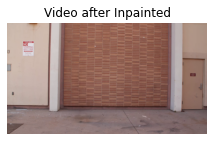

In [ ]:
#@title showing only the inpainting video
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.axis('off'); ax1.set_title('Video after Inpainted')
# ax2 = fig.add_subplot(1,2,2)
# ax2.axis('off'); ax2.set_title('Our Result')
#imdata1 = ax1.imshow(frames_final[0])

imdata1 = ax1.imshow(comp_frames_final[0].astype(np.uint8))

def update(idx):
    #imdata1.set_data(frames_final[idx])
    imdata1.set_data(comp_frames_final[idx].astype(np.uint8))

fig.tight_layout()
anim = animation.FuncAnimation(fig, update, frames=len(comp_frames_final), interval=50)
from IPython.display import HTML
HTML(anim.to_html5_video())

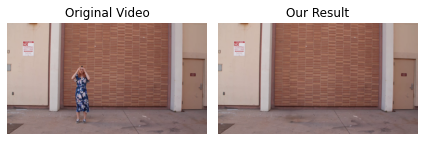

In [ ]:
#@title showing the inpainting video and the original video
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.axis('off'); ax1.set_title('Original Video')
ax2 = fig.add_subplot(1,2,2)
ax2.axis('off'); ax2.set_title('Our Result')
imdata1 = ax1.imshow(frames_final[0])
imdata2 = ax2.imshow(comp_frames_final[0].astype(np.uint8))

def update(idx):
    imdata1.set_data(frames_final[idx])
    imdata2.set_data(comp_frames_final[idx].astype(np.uint8))

fig.tight_layout()
anim = animation.FuncAnimation(fig, update, frames=len(comp_frames_final), interval=50)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
#DEL AT END TO SAVE SPACE
del comp_frames_final
del frames_final